In [4]:
# 문제5) 이미지 분류

# Roboflow Public Datasets 사용
#  - Rock Paper Scissors Classification Dataset : “바위/보/가위” 손 모양 이미지( 약 2,925장 ). 클래스도 3개, 컬러 이미지. 
#    https://public.roboflow.com/classification/rock-paper-scissors?utm_source=chatgpt.com

In [5]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:
np.random.seed(0)
tf.random.set_seed(3)

In [7]:
IMG_SIZE = (224, 224)   # 필요에 따라 (128, 128) 등으로 변경
BATCH = 32

train_dir = "data/rock-paper-scissors/train"
valid_dir = "data/rock-paper-scissors/valid"
test_dir  = "data/rock-paper-scissors/test"

# 디렉터리에서 이미지 분류용 데이터셋 만들기
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="categorical",             # [0..C-1] 정수 라벨
    image_size=IMG_SIZE,
    batch_size=BATCH,
    shuffle=True,
    seed=42,
)

valid_ds = tf.keras.utils.image_dataset_from_directory(
    valid_dir,
    labels="inferred",
    label_mode="categorical",
    image_size=IMG_SIZE,
    batch_size=BATCH,
    shuffle=True,
    seed=42,
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="categorical",
    image_size=IMG_SIZE,
    batch_size=BATCH,
    shuffle=False
)

# 클래스 이름 확인
class_names = train_ds.class_names
print("class_names:", class_names)    # 예: ['paper', 'rock', 'scissors']
# --- feature와 label 일부 출력 ---
# for images, labels in train_ds.take(1):
#     print("features shape:", images.shape)   # (B, H, W, 3)
#     print("labels shape:", labels.shape)     # (B,)
#     print("labels (first 10):", labels[:10].numpy())
#     print("labels mapped (first 10):", [class_names[i] for i in labels[:10].numpy()])

Found 2520 files belonging to 3 classes.
Found 372 files belonging to 3 classes.
Found 33 files belonging to 3 classes.
class_names: ['paper', 'rock', 'scissors']


In [8]:
def normalize_image(image, label):
    return image / 255.0, label

In [9]:
train_ds = train_ds.map(normalize_image, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.map(normalize_image, num_parallel_calls=tf.data.AUTOTUNE)
valid_ds = valid_ds.map(normalize_image, num_parallel_calls=tf.data.AUTOTUNE)

In [33]:
# CNN model
model1 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(224, 224, 3)),
    
    # 데이터 특징 추출 레이어
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(rate=0.1),
    
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(rate=0.1),

    tf.keras.layers.Flatten(),

    # 분류기 레이어
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dropout(rate=0.3),
    
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dropout(rate=0.3),
    
    tf.keras.layers.Dense(units=3, activation='softmax')
])

model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model1.summary())

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │    25,690,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,718,083 (98.11 MB)

 Trainable params: 25,718,083 (98.11 MB)

 Non-trainable params: 0 (0.00 B)

None


In [34]:
earlystop = EarlyStopping(monitor='val_loss', patience=5)

In [35]:
history1 = model1.fit(train_ds, validation_data=valid_ds, epochs=100, batch_size=1, verbose=1, callbacks=[earlystop])

Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 35s 431ms/step - accuracy: 0.6810 - loss: 1.4376 - val_accuracy: 0.7070 - val_loss: 0.7485
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 32s 401ms/step - accuracy: 0.9821 - loss: 0.0689 - val_accuracy: 0.7903 - val_loss: 0.6927
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 32s 401ms/step - accuracy: 0.9901 - loss: 0.0301 - val_accuracy: 0.7581 - val_loss: 0.8350
Epoch 4/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 32s 406ms/step - accuracy: 0.9956 - loss: 0.0134 - val_accuracy: 0.7984 - val_loss: 0.8043
Epoch 5/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 32s 403ms/step - accuracy: 0.9972 - loss: 0.0086 - val_accuracy: 0.7742 - val_loss: 1.0462
Epoch 6/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 32s 398ms/step - accuracy: 0.9984 - loss: 0.0057 - val_accuracy: 0.7984 - val_loss: 0.9828
Epoch 7/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 32s 399ms/step - accuracy: 0.9976 - loss: 0.0077 - val_accuracy: 0.7581 - val_loss: 1.1412


In [36]:
print('Test accuracy: %.4f'%(model1.evaluate(test_ds)[1]))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6364 - loss: 1.7999
Test accuracy: 0.6364


In [11]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.027), 
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
])

def augment_data(image, label):
    image = tf.cast(image, tf.float32)
    return data_augmentation(image), label

In [12]:
augmented_ds = train_ds.shuffle(buffer_size=1024).map(augment_data, num_parallel_calls=tf.data.AUTOTUNE)

In [44]:
# CNN model
model2 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(224, 224, 3)),
    
    # 데이터 특징 추출 레이어
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(rate=0.1),
    
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(rate=0.1),

    tf.keras.layers.Flatten(),

    # 분류기 레이어
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dropout(rate=0.3),
    
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dropout(rate=0.3),
    
    tf.keras.layers.Dense(units=3, activation='softmax')
])

model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model2.summary())

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │    25,690,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,718,083 (98.11 MB)

 Trainable params: 25,718,083 (98.11 MB)

 Non-trainable params: 0 (0.00 B)

None


In [40]:
history2 = model2.fit(augmented_ds, validation_data=valid_ds, epochs=100, batch_size=1, verbose=1, callbacks=[earlystop])

Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 34s 408ms/step - accuracy: 0.3532 - loss: 1.7168 - val_accuracy: 0.5134 - val_loss: 1.0970
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 32s 399ms/step - accuracy: 0.5488 - loss: 0.9920 - val_accuracy: 0.8065 - val_loss: 0.8063
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 32s 399ms/step - accuracy: 0.7782 - loss: 0.5591 - val_accuracy: 0.9167 - val_loss: 0.3026
Epoch 4/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 33s 403ms/step - accuracy: 0.9048 - loss: 0.2959 - val_accuracy: 0.9274 - val_loss: 0.2344
Epoch 5/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 33s 412ms/step - accuracy: 0.9262 - loss: 0.2379 - val_accuracy: 0.9758 - val_loss: 0.1257
Epoch 6/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 33s 404ms/step - accuracy: 0.9472 - loss: 0.1722 - val_accuracy: 0.9543 - val_loss: 0.1288
Epoch 7/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 33s 408ms/step - accuracy: 0.9444 - loss: 0.1565 - val_accuracy: 0.9919 - val_loss: 0.0747
Epoch 8/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 33s 405ms/step - accuracy: 0.9603 - loss: 0.1299 - 

In [41]:
print('Test accuracy: %.4f'%(model2.evaluate(test_ds)[1]))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9394 - loss: 0.2015 
Test accuracy: 0.9394


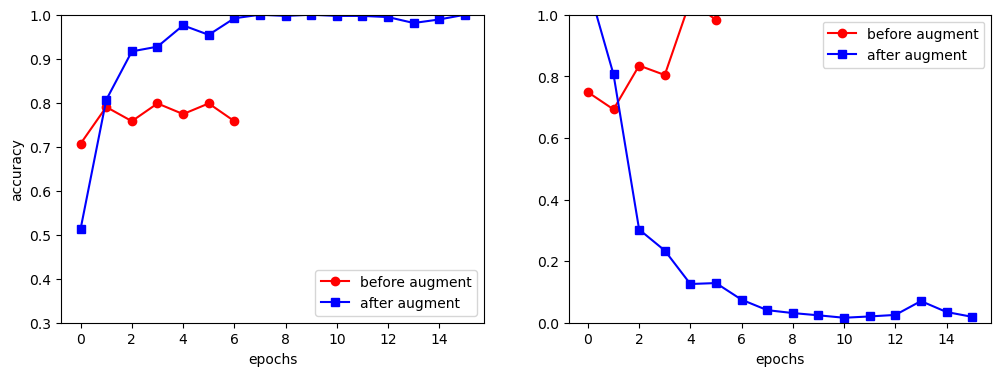

In [42]:
# 시각화
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history1.history['val_accuracy'], marker='o', c='red', label='before augment')
plt.plot(history2.history['val_accuracy'], marker='s', c='blue', label='after augment')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.ylim(0.3, 1)
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history1.history['val_loss'], marker='o', c='red', label='before augment')
plt.plot(history2.history['val_loss'], marker='s', c='blue', label='after augment')
plt.xlabel('epochs')
plt.ylim(0.0, 1)
plt.legend(loc='upper right')

plt.show()
plt.close()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step 


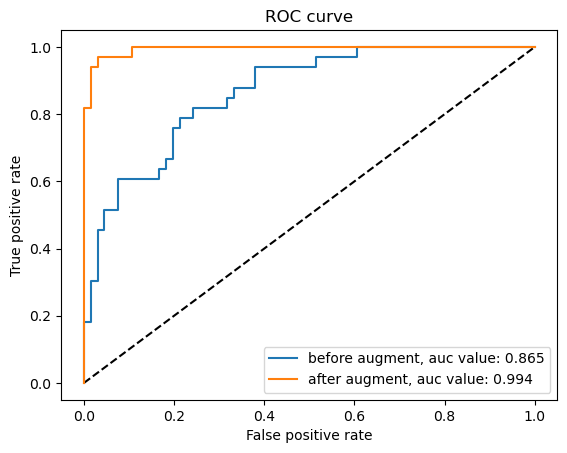

In [43]:
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
    
y_pred = model1.predict(test_ds)
true_labels = np.concatenate([labels for _, labels in test_ds], axis=0)
fpr, tpr, _ = roc_curve(true_labels.ravel(), y_pred.ravel())
plt.plot(fpr, tpr, label='{}, auc value: {:.3f}'.format('before augment', auc(fpr, tpr)))

y_pred = model2.predict(test_ds)
true_labels = np.concatenate([labels for _, labels in test_ds], axis=0)
fpr, tpr, _ = roc_curve(true_labels.ravel(), y_pred.ravel())
plt.plot(fpr, tpr, label='{}, auc value: {:.3f}'.format('after augment', auc(fpr, tpr)))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend()
plt.show()
plt.close()